Tutorial 3 - Dynamic Flowsheets
=============================

Introduction
------------

The previous [tutorials](https://idaes-pse.readthedocs.io/en/latest/examples/index.html) have looked at developing flowsheets for steady-state processes, however it is often important to study how a process behaves under transient conditions. This tutorial will demonstrate how to create a model for a dynamic process using the IDAES modeling framework.

For this tutorial, we will use a similar process to the previous tutorials, using two CSTRs to perform a simple chemical reaction. However, for this tutorial we will add a second feed stream and a mixer unit before the first reactor, to represent the mixing of two reactant streams as shown below.

<img src="mix_2cstrs.png">

<center>ethyl acetate + NaOH $\rightarrow$ sodium acetate + ethanol</center>

In this tutorial, you will learn how to:

* setup a dynamic flowsheet and define the time domain
* add additional variables and constraints to a Unit Model
* transform a time domain to automatically populate the time domain and define derivative terms
* set initial conditions for a dynamic model
* initialize and solve a dynamic model
* introduce a step change to the model
* plot profiles of key variables as a function of time

Importing Libraries
----------------------------

As before, the first step in creating our model is to import the necessary components from Python, Pyomo and IDAES. The components we will require are discussed below.

Firstly, we need all the components from Pyomo that we have used in the previous tutorials (`ConcreteModel`, `SolverFactory` and `TransformationFactory` from `pyomo.environ` and `Arc` from `pyomo.network`). In addition to this, we are going to need the `Constraint` and `Var` components from `pyomo.environ` in order to add additional variables and constraints to our model.

Import these components below:

In [1]:
from pyomo.environ import ConcreteModel, Constraint, Objective, SolverFactory, TransformationFactory, Constraint, Var
from pyomo.network import Arc

Next, we will need the IDAES components we have used in the previous tutorials:

`FlowsheetBlock` from `idaes.core`

`idaes.property_models.examples.saponification_thermo`

`idaes.property_models.examples.saponification_reactions`

`CSTR` from `idaes.unit_models`

We will also need the [Mixer](https://idaes-pse.readthedocs.io/en/latest/models/mixer.html) model from the IDAES unit model library (`idaes.unit_models`)

Import these components below:

In [2]:
from idaes.core import FlowsheetBlock
from idaes.unit_models import CSTR, Mixer
import idaes.property_models.examples.saponification_thermo as thermo_props
import idaes.property_models.examples.saponification_reactions as reaction_props

Finally, we are going to need a tool for plotting our results. For this tutorial, we will use the `pyplot` tool in `matplotlib` (part of most scientific Python distributions), which we will import as `plt` for convenience.

If you do not have `matplotlib` installed in your Python distribution, see your Python package manager for details on how to install it.

The code to import `pyplot` is given below.

In [3]:
import matplotlib.pyplot as plt

Creating Our Model
-----------------------------

Now that we have imported all the tools we will need, we can begin constructing our model. As before, the first step is to create a `ConcreteModel` to hold our flowsheet.

In [4]:
m = ConcreteModel()

Next, we add a `FlowsheetBlock` to our model. In previous tutorials, we have set the `dynamic` argument to be `False`, indicating a steady-state flowsheet. In this case however, we wish to create a dynamic flowsheet, so we set this argument to `True`.

Additionally, for a dynamic model, we need to provide some information about the time domain for our model. At a minimum, we need to set the start and end times for our time domain, which for this case will be 0 and 20 seconds respectively. We can also specify specific time points that we wish to ensure are in our time domain, such as points where we know a step-change will occur. Later in this tutorial we will introduce a step-change at t = 1 second, so we will include this in our time domain now.

Thus, we want to create a time domain that begins at t = 0, has a point at t = 1 and ends at t = 20. To do this, we use the `time_set` argument when creating our `FlowsheetBlock` and provide these values as a Python list (or equivalent) - i.e. `time_set: [0, 1, 20]` (note that the time values may be integers or floating point numbers at this stage). **Note:** If a `time_set` is not provided when creating a dynamic flowsheet, a default time domain of `[0, 1]` will be used.

The code to do this is shown below, and more details on `Flowsheet` options and arguments are available [here](https://idaes-pse.readthedocs.io/en/latest/core/flowsheet_model.html):

In [5]:
m.fs = FlowsheetBlock(default={"dynamic": True, "time_set": [0, 1, 20]})

To see what happened in this step, let us `display` the time domain of our flowsheet.

In [6]:
m.fs.time.display()

time : Dim=0, Dimen=1, Size=3, Domain=None, Ordered=Sorted, Bounds=(0.0, 20.0)
    [0.0, 1.0, 20.0]


We should see the following:

```
time : Dim=0, Dimen=1, Size=3, Domain=None, Ordered=Sorted, Bounds=(0.0, 20.0)
    [0.0, 1.0, 20.0]
```

This shows us that our `time` domain is a sorted Pyomo `Set` (`Ordered=Sorted`) with points at 0.0, 1.0 and 20.0 and bounds of 0.0 and 20.0. This is what we would expect, as we told the `FlowsheetBlock` to create a time domain with these points.

The fact that the `Set` is sorted is important, as it indicates the points in the `Set` are in order, allowing us to find the next and previous points if required.

Next we need to add the property parameter blocks to our flowsheet, which is done in the same way as for steady-state flowsheets. Remember to link the `ReactionParameterBlock` to the `PhysicalParameterBlock`.

In [7]:
m.fs.thermo_params = thermo_props.SaponificationParameterBlock()

In [8]:
m.fs.reaction_params = reaction_props.SaponificationReactionParameterBlock(
                        default={"property_package": m.fs.thermo_params})

Just as for steady-state models, the next step is to add the necessary unit models to our flowsheet. As we have declared our flowsheet to be a dynamic flowsheet, all unit models within it will automatically be assumed to be dynamic unit operations. However, there are some cases where we might want to place a steady-state model within an otherwise dynamic flowsheet (e.g. for a unit with a very fast response time relative to the rest of the process). The IDAES framework supports this by allowing us to specifically state that a unit operation is steady-state, overriding the automatic assumption of a dynamic unit. Note that the opposite is not true, and that we cannot place dynamic models within a steady-state flowsheet.

In our flowsheet, the first unit operation is a `Mixer` unit. Normally we assume an ideal mixer, which has zero volume and thus no holdup or accumulation - i.e. it is effectively a steady-state unit operation (in more rigorous models we might use a tank model to represent a real mixer). Thus, let us add a `Mixer` unit to our flowsheet and declare it to be a steady-state unit operation. To do this, we simply pass the following argument to the unit model as we construct it: `"dynamic": False` to indicate that the model should be a steady-state model. A `Mixer` unit also requires a physical property package (but not a reaction package) to define the list of components that are present in the unit, so we also need to pass the `"property_package"` argument pointing to the appropriate `PhysicalParameterBlock`. More details on the `Mixer` model is available [here](https://idaes-pse.readthedocs.io/en/latest/models/mixer.html)

In [9]:
m.fs.mix = Mixer(default={"dynamic": False,
                          "property_package": m.fs.thermo_params})

Next, we need to add the two `CSTR` units to our flowsheet, which is done in the same way as in the previous tutorials.

In [10]:
m.fs.Tank1 = CSTR(default={"property_package": m.fs.thermo_params,
                           "reaction_package": m.fs.reaction_params,
                           "has_equilibrium_reactions": False,
                           "has_heat_of_reaction": True,
                           "has_heat_transfer": True,
                           "has_pressure_change": False})
m.fs.Tank2 = CSTR(default={"property_package": m.fs.thermo_params,
                           "reaction_package": m.fs.reaction_params,
                           "has_equilibrium_reactions": False,
                           "has_heat_of_reaction": True,
                           "has_heat_transfer": True,
                           "has_pressure_change": False})

Whilst the unit models alone are sufficient for a steady-state flowsheet, dynamic flowsheets require extra constraints to determine the flow of material in the process. In most cases, we need to write a set of pressure-flow constraints for each dynamic unit in the process to determine the rate at which material leaves the unit.

For this tutorial, we will write a set of simple constraints for each CSTR with the form:

<center>$F = C \times \sqrt h$</center>

where $F$ is volumetric flowrate, $C$ is a flow coefficient and $h$ is the depth of fluid within the CSTR. Additionally, we will need a constraint that relates depth to the volume of the tank:

<center>$V = A \times h$</center>

where $V$ is volume and $A$ is the cross-section area of the tank.

To do this, first we need to create some new variables in our CSTR units. The CSTRs already have variables for the volume and the volumetric flowrate, so we need to create new variables for the flow coefficient, depth and area. To do this, we create new Pyomo `Var` objects in each CSTR. To create a `Var` for area, we do the following:

In [11]:
m.fs.Tank1.area = Var(initialize=1.0,
                      doc="Cross-sectional area of tank [m^2]")

Here, we are creating a new `Var` object named `area` within the first CSTR (`m.fs.Tank1`). We have also given it an initial value of 1.0 using the `initialize` argument, and a documentation string to explain what the variable is (through the `doc` argument).

In the case of `area`, we know that it will not vary with time and thus we created a single `Var` to represent the area at all points in time. However, we expect the depth and potentially the flow coefficient to vary with time as the amount of fluid in the reactor and the valve opening changes. For these variables, we need to create `Var` objects which are indexed by `time`. In Pyomo (and thus IDAES), this is done by providing the indexing set (or indexing sets) as arguments when creating the `Var` object (or any other component).

For example, we create the flow coefficient as shown below:

In [12]:
m.fs.Tank1.flow_coeff = Var(m.fs.time,
                            initialize=5e-5,
                            doc="Tank outlet flow coefficient")

Now try creating a `Var` named `height` below to represent the depth of fluid in the reactor.

In [13]:
m.fs.Tank1.height = Var(m.fs.time,
                        initialize=1.0,
                        doc="Tank height [m]")

Now that we have the variables we need to represent the pressure driven flow, we need to write the `Constraints` which relate these. Let us start with the simpler of the two constraints, namely $V = A \times h$.

To begin with, each of the `Constraints` we are going to construct need to be indexed by `time`, as they involve `Vars` that are indexed by time. To do this, we need to create a method or rule which tells Pyomo how to construct the `Constraint`. For this, we declare a method using the Python `def` keyword followed by a name for the method (which we will call `geometry`). This is followed by a pair of parentheses which contain the following arguments for our method:

* the first argument is a placeholder for the model on which the `Constraint` will be constructed. This name can be anything you want (as it is just a placeholder), but within IDAES we tend to use either b (for "block") or m (for "model).
* placeholders for each index that will be used in the `Constraint`. In our case our only index is `time` (which we will represent with t), but there can be as many indexes as required.

The result is the following:

```
def geometry(m, t):
```

Note that the line of code ends with a `:`.

Next, we need to add the body of our method, which needs to return an *expression* that describes the `Constraint` to be written at each combination of indices. More complex `Constraints` may involve `if/else` statements here, but in our case we wish to have the same form of the expression at all points in time, namely $V_t = A \times h_t$. To achieve this, we write the following:

```
    return m.volume[t] == m.area*m.height[t]
```

Firstly, note that this line of code is indented - this is Python notation to show that this line of code is part of the previously declared method. Next, the line begins with a `return` command, which indicates that the method will return the result of this line to whatever called it (which will be the `Constraint` constructor in our case). Finally, the rest of the line is the *expression* that we wish to return. You will see that we have used our placeholder for the model (`m`) when referencing the `Vars` in that model, and that we have included time indices on the appropriate `Vars` (using `[t]`).

Lastly, we need to add the actual `Constraint` to our model. Similar to adding a `Var` to our CSTRs, we now add a `Constraint` to the CSTR by declaring a `Constraint` with the name `geometry` and passing the following arguments to it:

* the first index (or indices) are the indexing sets for the `Constraint`
* we set the rule for the `Constraint` using the `rule` argument, and point it to the method we just wrote.

```
m.fs.Tank1.geometry = Constraint(m.fs.time, rule=geometry)
```

The completed code is shown below for you to run.

In [14]:
def geometry(m, t):
    return m.volume[t] == m.area*m.height[t]

m.fs.Tank1.geometry = Constraint(m.fs.time, rule=geometry)

Next, we need to add the `Constraint` for $F_t = C_t \times \sqrt h_t$. We use the same steps as above, but in this case we have one minor complication - what is the name of the variable for $F_t$? We created `Vars` for $C$ and $h$ ourselves, but $F$ is constructed as part of the `CSTR` model, so we need to go and find its name.

To do this, we need to understand something about the structure of the `CSTR` model (and IDAES models in general). Unit models within IDAES (or at least the core model libraries) use a standardized structure based on the concept of [*control volumes*](https://idaes-pse.readthedocs.io/en/latest/core/control_volume.html) . Each unit model contains one or more control volumes, which represent distinct volumes of fluid over which material, energy and momentum balances will be written. Each control volume then contains a number of *state blocks* which contain the information on the state of the material at a specific time and location within the control volume (both extensive and intensive).

The structure of unit models will be discussed more in later tutorials, but for now it is sufficient to know that our `CSTR` contains a single control volume (named `control_volume`), with two state blocks named `properties_in` and `properties_out` which are indexed by time.

So, we want the volumetric flowrate of material leaving the CSTR. The IDAES documentation contains a list of [standard names](https://idaes-pse.readthedocs.io/en/latest/standards.html#standard-variable-names) for common properties, which shows us that volumetric flowrate should be named `flow_vol`, so the variable we want (at time $t$) should be called:

```
tank.control_volume.properties_out[t].flow_vol
```

Thus, the code to construct the pressure driven flow constraint is:

In [15]:
def outlet_flowrate(m, t):
    return m.control_volume.properties_out[t].flow_vol == m.flow_coeff[t]*m.height[t]**0.5

m.fs.Tank1.outlet_flowrate = Constraint(m.fs.time, rule=outlet_flowrate)

We now need to do the same procedure for `Tank2`. First, try creating the three `Vars` (`area`, `height` and `flow_coeff`) required for the `Constraints` in `Tank2` (don't forget to change the name of the tank if you copy from the code above).

In [16]:
m.fs.Tank2.area = Var(initialize=1.0,
                      doc="Cross-sectional area of tank [m^2]")
m.fs.Tank2.flow_coeff = Var(m.fs.time,
                            initialize=5e-5,
                            doc="Tank outlet flow coefficient")
m.fs.Tank2.height = Var(m.fs.time,
                        initialize=1.0,
                        doc="Tank height [m]")

Next, we need to construct the `Constraints` for `Tank2`. One of the good things about the way Pyomo and Python work is that we can create general methods to do common tasks to prevent ourselves from having to repeat our code. If you look at the methods we wrote whilst creating the `Constraints` for `Tank1`, you might notice that the rules are in fact general - we used a placeholder `b` in place of specific unit names, so we can actually reuse the same methods for `Tank2`. All we need to do is create the `Constraint` objects on `Tank2` as we did before and pass the same rule:

In [17]:
m.fs.Tank2.geometry = Constraint(m.fs.time, rule=geometry)
m.fs.Tank2.outlet_flowrate = Constraint(m.fs.time, rule=outlet_flowrate)

Connecting the Flowsheet
--------------------------------------

Now that we have all the unit models and associated constraints in our flowsheet, the next step is to define the connectivity between units. This is mostly the same as for steady-state flowsheets with one additional step required.

Firstly, we need to define the `Arcs` which connect our units together. We need to define the following `Arcs` for our flowsheet:

* an Arc connecting the outlet of `mix` to the inlet of `Tank1`
* an Arc connecting the outlet of `Tank1` to the inlet of `Tank2`

Do this below:

In [18]:
m.fs.stream1 = Arc(source=m.fs.mix.outlet,
                  destination=m.fs.Tank1.inlet)
m.fs.stream2 = Arc(source=m.fs.Tank1.outlet,
                  destination=m.fs.Tank2.inlet)

Next, we need to perform an additional step that is not present when we are working with a steady-state flowsheet. When we created our `time` domain, we only populated it with three time points (0.0, 1.0 and 20.0) which is insufficient for accurately modeling our process. At this point we need to fill in the time domain with a sufficient number of points, and also to write constraints approximating the derivative terms within our models (i.e. accumulation terms). Thankfully, Pyomo offers a tool to automate this process for us through the `TransformationFactory`.

We have already used the `TransformationFactory` before when expanding `Arcs` in the previous tutorials - the `TransformationFactory` is a general purpose interface within Pyomo for employing tools to transform your model from one form into another. In this case, we are going to transform our model in Differential Algebraic Equation form into a numerical approximation of the model.

When working with a `time` domain, the most common numerical approximation for the temporal derivatives is done using a first order backwards finite difference method, which we will use here (Pyomo offers a number of different discretization schemes, which can be found [here](https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html)). We also need to decide upon how many time points we will use in discretizing our model, which depends upon the response time of our process. In this case, we will use 200 discretization points.

To transform our time domain, we apply the following transformation:

In [19]:
m.discretizer = TransformationFactory('dae.finite_difference')
m.discretizer.apply_to(m,
                       nfe=200,
                       wrt=m.fs.time,
                       scheme="BACKWARD")

First, we create a `TransformationFactory` object using the `'dae.finite_difference'` method, which allows us to apply a number of different finite difference methods to a model.

We then apply this transformation to our model, and indicate the number of finite elements (`nfe`), the domain to be discretized (`m.fs.time`) and the discretization scheme to use (`"BACKWARD"` indicating a 1st order backwards finite difference).

To see an indication of what this has done to our model, let us display the time domain again:

In [20]:
m.fs.time.display()

time : Dim=0, Dimen=1, Size=201, Domain=None, Ordered=Sorted, Bounds=(0.0, 20.0)
    [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.074219, 1.148438, 1.296875, 1.445312, 1.519531, 1.59375, 1.667969, 1.742188, 1.890625, 2.039062, 2.113281, 2.1875, 2.261719, 2.335938, 2.484375, 2.632812, 2.707031, 2.78125, 2.855469, 2.929688, 3.078125, 3.226562, 3.300781, 3.375, 3.449219, 3.523438, 3.671875, 3.820312, 3.894531, 3.96875, 4.042969, 4.117188, 4.265625, 4.414062, 4.488281, 4.5625, 4.636719, 4.710938, 4.859375, 5.007812, 5.082031, 5.15625, 5.230469, 5.304688, 5.453125, 5.601562, 5.675781, 5.75, 5.824219, 5.898438, 6.046875, 6.195312, 6.269531, 6.34375, 6.417969, 6.492188, 6.640625, 6.789062, 6.863281, 6.9375, 7.011719, 7.085938, 7.234375, 7.382812, 7.457031, 7.53125, 7.605469, 7.679688, 7.828125, 7.976562, 8.050781, 8.125, 8.199219, 8.273438, 8.421875, 8.570312, 8.644531, 8.71875, 8.792969, 8.867188, 9.015625, 9.164062, 9.238281, 9.3125, 9.386719, 9.460938, 9.609375, 9.757812, 9.83

Last time we displayed the `time` domain, it contained only three points. We can now see that the `time` domain contains many more points - 201 in fact as indicated by the `Size` attribute in the first line. As we told the transformation to use 200 finite elements, this is what we would expect ((number of elements plus 1) points).

After we have transformed the `time` domain, we can then expand the `Arcs` in our model as we did in the previous tutorials. It is important to note that the two transformation steps must be performed in this order due to the way the Pyomo transformations work (it is hoped to address this in the future to make the steps order independent).

In [21]:
TransformationFactory("network.expand_arcs").apply_to(m)

Setting Inlet, Design and Initial Conditions
------------------------------------------------------------------

As before, the next step is to begin fixing those conditions we know in our process. However, there are some important differences between steady-state and dynamic models that you need to be aware of.

Firstly, let us fix the inlet conditions for our model. In this tutorial, we have added a mixer before the first tank, so we need to set conditions for both streams. As our starting point, let us use the following conditions:

**Inlet 1**

* flow_vol = 0.5
* conc_mol_comp["H2O"] = 55388.0
* conc_mol_comp["NaOH"] = 100.0
* conc_mol_comp["EthylAcetate"] = 0.0
* conc_mol_comp["SodiumAcetate"] = 0.0
* conc_mol_comp["Ethanol"] = 0.0
* temperature = 303.15
* pressure = 101325.0

**Inlet 2**

* flow_vol = 0.5
* conc_mol_comp["H2O"] = 55388.0
* conc_mol_comp["NaOH"] = 0.0
* conc_mol_comp["EthylAcetate"] = 100.0
* conc_mol_comp["SodiumAcetate"] = 0.0
* conc_mol_comp["Ethanol"] = 0.0
* temperature = 303.15
* pressure = 101325.0

So, we have one stream containing only water and NaOH, and one of only water and EthylAcetate.

More importantly however, unlike in previous tutorials, we need to fix the feed conditions at *ALL* points in time. In the previous tutorials, we explicitly fixed the conditions at time 0 because that was the only point in the `time` domain - e.g. `m.fs.Tank1.inlet.conc_mol_comp[0, "H2O"].fix(55388.0)`

There are many ways we could fix the conditions at all points in time, such as iterating over all points in the time domain. However, Pyomo offers tools which can do this very easily.

If the variable has the same value at ALL points across all indices, we can use the following:

`m.fs.mix.inlet_1.flow_vol.fix(0.5)`

This fixes all values (at all combinations of indices) of the variable to the given value

For cases where we have multiple indices and wish to fix the value at one value across the full range of one index, but different values in another, we can use *slice notation*. For example:

`m.fs.mix.inlet_1.conc_mol_comp[:, "H2O"].fix(55388.0)`

This fixed the value of the variable `m.fs.mix.inlet_1.conc_mol_comp` to 55388.0 at all points in the first index (`time`) where the second index is `"H2O"`.

To demonstrate this, the following code fixes the inlet conditions for `inlet_1` in the mixer for our process.

In [22]:
m.fs.mix.inlet_1.flow_vol.fix(0.5)
m.fs.mix.inlet_1.conc_mol_comp[:, "H2O"].fix(55388.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "NaOH"].fix(100.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "EthylAcetate"].fix(0.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "SodiumAcetate"].fix(0.0)
m.fs.mix.inlet_1.conc_mol_comp[:, "Ethanol"].fix(0.0)
m.fs.mix.inlet_1.temperature.fix(303.15)
m.fs.mix.inlet_1.pressure.fix(101325.0)

Try to set the conditions for `inlet_2` below.

In [23]:
m.fs.mix.inlet_2.flow_vol.fix(0.5)
m.fs.mix.inlet_2.conc_mol_comp[:, "H2O"].fix(55388.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "NaOH"].fix(0.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "EthylAcetate"].fix(100.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "SodiumAcetate"].fix(0.0)
m.fs.mix.inlet_2.conc_mol_comp[:, "Ethanol"].fix(0.0)
m.fs.mix.inlet_2.temperature.fix(303.15)
m.fs.mix.inlet_2.pressure.fix(101325.0)

Next, we need to fix the design conditions for the unit operations in our process. The conditions we need to set are:

* `area` of both tanks = 1
* `flow_coeff` of both tanks = 0.5
* `heat_duty` of both tanks = 0.0

Fix these conditions for both `Tank1` and `Tank2` below:

In [24]:
m.fs.Tank1.area.fix(1.0)
m.fs.Tank1.flow_coeff.fix(0.5)
m.fs.Tank1.heat_duty.fix(0.0)

m.fs.Tank2.area.fix(1.0)
m.fs.Tank2.flow_coeff.fix(0.5)
m.fs.Tank2.heat_duty.fix(0.0)

In addition to feed and design conditions, dynamic process models also require us to define the initial conditions for the process. There are many potential initial conditions we may want to study, but the simplest of these is to assume the process exists at steady-state at the beginning of the simulation. To do this, we need to set all the temporal derivatives to zero at the first time point.

Rather than having to do this manually, the IDAES framework provides a method to do this for us automatically:

In [25]:
m.fs.fix_initial_conditions()

There is also an equivalent `unfix_initial_conditions` method which will unfix all temporal derivatives at the first point in the `time` domain if required. Documentation on these methods is available [here](https://idaes-pse.readthedocs.io/en/latest/core/process_block.html).

Initializing the Model
------------------------------

At this point, our model should be fully constructed and defined, so we can start on the process of initializing and solving our model. The first unit in our flowsheet is the `Mixer`, which should be fully defined with all inlets fixed. Thus, we can call the `initialize` method of the mixer with no additional arguments.

Call the mixer initialization method below:

In [26]:
m.fs.mix.initialize()

2020-04-24 12:53:15 - INFO - idaes.property_models.examples.saponification_thermo - fs.mix.mixed_state Initialization Complete.
2020-04-24 12:53:16 - INFO - idaes.property_models.examples.saponification_thermo - fs.mix.inlet_1_state State Released.
2020-04-24 12:53:16 - INFO - idaes.property_models.examples.saponification_thermo - fs.mix.inlet_2_state State Released.


Next, we need to initialize the first `CSTR`. In the previous tutorials, we simply used the inlet conditions to initialize subsequent units, but this is almost always a poor guess for initial conditions. Unit operations by definition represent a change in state between inlet and outlet, and conditions in dynamic models inherently vary with time. Thus initializing to a single state throughout the process is a poor choice.

For this tutorial, we will demonstrate how to use the initialized outlet of a previous unit to initialize the next unit in a process. As our initial process is at steady-state, we will not consider variances in the state as a function of time. At present, passing values from the outlet of one unit to the inlet of another is a manual process, however tools are being developed to assist with this.

In the previous tutorials, we initialized the second tank using the following code:

```
m.fs.Tank2.initialize(state_args={
        "flow_vol": 1.0,
        "conc_mol_comp": {"H2O": 55388.0,
                          "NaOH": 100.0,
                          "EthylAcetate": 100.0,
                          "SodiumAcetate": 0.0,
                          "Ethanol": 0.0},
        "temperature": 303.15,
        "pressure": 101325.0})
```

In this case, we were passing fixed values for each state variable to the initialization method to use as initial guesses. In this tutorial, we will replace these fixed values with values taken from the outlet of the previous unit. To get the value of a state in the outlet of another unit, we simply need to point to the specific unit and outlet, e.g. `m.fs.mix.outlet` and the variable of interest within that outlet, e.g. `flow_vol` and ask for the value of that variable using the `value` attribute.

For example, the following line of code will get the value of the volumetric flowrate in the outlet of the mixer at time 0:

`m.fs.mix.outlet.flow_vol[0].value`

It is important to note that we need the `time` index when asking for a value. `flow_vol` itself does not have a `value`, rather it is a collection of values at each point in `time`. Thus, to get an actual value for the variable, we have to ask for it at a specific point in `time`. For this tutorial, we will use the value at `time=0`.

Thus, to initialize `Tank1`, we use the following code:

In [27]:
m.fs.Tank1.initialize(state_args={
            "flow_vol": m.fs.mix.outlet.flow_vol[0].value,
            "conc_mol_comp": {"H2O": m.fs.mix.outlet.conc_mol_comp[0, "H2O"].value,
                              "NaOH": m.fs.mix.outlet.conc_mol_comp[0, "NaOH"].value,
                              "EthylAcetate": m.fs.mix.outlet.conc_mol_comp[0, "EthylAcetate"].value,
                              "SodiumAcetate": m.fs.mix.outlet.conc_mol_comp[0, "SodiumAcetate"].value,
                              "Ethanol": m.fs.mix.outlet.conc_mol_comp[0, "Ethanol"].value},
            "temperature": m.fs.mix.outlet.temperature[0].value,
            "pressure": m.fs.mix.outlet.pressure[0].value})

2020-04-24 12:53:17 - INFO - idaes.property_models.examples.saponification_thermo - fs.Tank1.control_volume.properties_out Initialization Complete.
2020-04-24 12:53:17 - INFO - idaes.property_models.examples.saponification_reactions - fs.Tank1.control_volume.reactions Initialization Complete.
2020-04-24 12:53:18 - INFO - idaes.property_models.examples.saponification_thermo - fs.Tank1.control_volume.properties_in State Released.


Now that `Tank1` has been initialized, we can repeat the process for `Tank2`. Try to do this for below:

In [28]:
m.fs.Tank2.initialize(state_args={
            "flow_vol": m.fs.Tank1.outlet.flow_vol[0].value,
            "conc_mol_comp": {"H2O": m.fs.Tank1.outlet.conc_mol_comp[0, "H2O"].value,
                              "NaOH": m.fs.Tank1.outlet.conc_mol_comp[0, "NaOH"].value,
                              "EthylAcetate": m.fs.Tank1.outlet.conc_mol_comp[0, "EthylAcetate"].value,
                              "SodiumAcetate": m.fs.Tank1.outlet.conc_mol_comp[0, "SodiumAcetate"].value,
                              "Ethanol": m.fs.Tank1.outlet.conc_mol_comp[0, "Ethanol"].value},
            "temperature": m.fs.Tank1.outlet.temperature[0].value,
            "pressure": m.fs.Tank1.outlet.pressure[0].value})

2020-04-24 12:53:18 - INFO - idaes.property_models.examples.saponification_thermo - fs.Tank2.control_volume.properties_out Initialization Complete.
2020-04-24 12:53:18 - INFO - idaes.property_models.examples.saponification_reactions - fs.Tank2.control_volume.reactions Initialization Complete.
2020-04-24 12:53:19 - INFO - idaes.property_models.examples.saponification_thermo - fs.Tank2.control_volume.properties_in State Released.


Now that the each unit model has been initialized, we need to solve the entire model to finish initializing the constraints that link the units together (the `Arcs`).

Create a solver object below and use it solve the flowsheet.

In [29]:
solver = SolverFactory('ipopt')

Adding a Disturbance
--------------------------------

Before we move on, we should make sure that the previous `solve` found a feasible solution to the problem. Let us print the `results` object and check the solver status.

In [30]:
results = solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    48996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    11055

Total number of variables............................:    17274
                     variables with only lower bounds:     6030
                variables with lower and upper bounds:     2010
                     variables with only upper bounds:        0
Total

In [31]:
print(results)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 17274
  Number of variables: 17274
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.5862040519714355
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



Hopefully you will see that the solver found an optimal solution, and that there were 17274 variables and constraints in the problem. If the solver failed to find an optimal solution, or the number of variables and/or constraints is incorrect, you will need to go back and work out what is missing.

However, the problem we just solved is rather boring - the process is at steady-state and there are no changes in operating conditions. To get some more interesting results, let us add a step change in one of the feed streams at `time=1.0` (this is why we added a point at `time=1.0` back when we created the time domain).

To do this, we need a `for` loop which will iterate over time, and at any point where `time >= 1` we will change the concentration of EthylAcetate in `inlet_2` to the mixer to 90.0.

This is shown below:

In [32]:
for t in m.fs.time:
    if t >= 1.0:
        m.fs.mix.inlet_2.conc_mol_comp[t, "EthylAcetate"].fix(90.0)

Now, let us re-solve the problem with the step change. To do this, we can reuse the solver we created earlier, and just apply it to the updated model.

In [33]:
results = solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    48996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    11055

Total number of variables............................:    17274
                     variables with only lower bounds:     6030
                variables with lower and upper bounds:     2010
                     variables with only upper bounds:        0
Total

Once again, let us `print` the `results` to be sure the problem solved.

In [34]:
print(results)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 17274
  Number of variables: 17274
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Solved To Acceptable Level.
  Termination condition: optimal
  Id: 1
  Error rc: 0
  Time: 1.9958710670471191
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



Once again, you should see an optimal solution was found, and that there were 17274 variables and constraints.

Plotting the Results
-----------------------------

We now have some results to look at, but just printing the numbers to the screen will be difficult to interpret. Instead, let us plot the concentration profiles leaving both tanks as a function of time.

To start with, let us plot the profiles leaving `Tank1`. To do this, we will use the `pyplot` library we imported at the beginning of the tutorial (which we called `plt`). To start with, we need to create a new `figure` object to hold our plot.

In [35]:
plt.figure("Tank 1 Outlet")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Next, we need to add curves to the plot for each concentration profile and add a legend and some axis labels so that other people can read our plot.

To add a curve to a plot, we use the `plot` method which takes three arguments:

* the x-axis values,
* the y-axis values, and
* a label for the curve.

For the x-axis values we wish to use the `time` domain of our model, which we can use directly as `m.fs.time`. For the y-axis values, we need to use a slice of the `conc_mol_comp` variable at all points in `time` (`:`) and a specific component name. We also need to include the `.value` attribute in this case, as Pyomo `slicers` do not behave in the same way as the `time` domain.

To plot all the concentration profiles for the outlet of `Tank1`, we do the following:

Text(0, 0.5, 'Concentration [mol/m^3]')

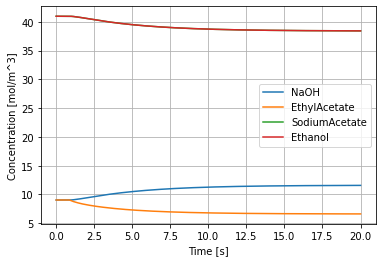

In [36]:
plt.plot(m.fs.time,
         list(m.fs.Tank1.outlet.conc_mol_comp[:, "NaOH"].value),
         label='NaOH')
plt.plot(m.fs.time,
         list(m.fs.Tank1.outlet.conc_mol_comp[:, "EthylAcetate"].value),
         label='EthylAcetate')
plt.plot(m.fs.time,
         list(m.fs.Tank1.outlet.conc_mol_comp[:, "SodiumAcetate"].value),
         label='SodiumAcetate')
plt.plot(m.fs.time,
         list(m.fs.Tank1.outlet.conc_mol_comp[:, "Ethanol"].value),
         label='Ethanol')
plt.legend()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Concentration [mol/m^3]")

Try to plot the concentration profiles leaving `Tank2` below.

Text(0, 0.5, 'Concentration [mol/m^3]')

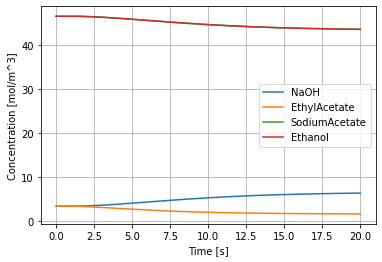

In [37]:
plt.plot(m.fs.time,
         list(m.fs.Tank2.outlet.conc_mol_comp[:, "NaOH"].value),
         label='NaOH')
plt.plot(m.fs.time,
         list(m.fs.Tank2.outlet.conc_mol_comp[:, "EthylAcetate"].value),
         label='EthylAcetate')
plt.plot(m.fs.time,
         list(m.fs.Tank2.outlet.conc_mol_comp[:, "SodiumAcetate"].value),
         label='SodiumAcetate')
plt.plot(m.fs.time,
         list(m.fs.Tank2.outlet.conc_mol_comp[:, "Ethanol"].value),
         label='Ethanol')
plt.legend()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Concentration [mol/m^3]")

Summary
--------------

Dynamic models have a number of differences when compared to steady-state models of an equivalent process. Most notable of course is the need for a discretized time domain with multiple time points which the user needs to be aware of. Additionally, there are a number of additional steps the user must take when setting up a dynamic problem. Below is a summary of the key differences in setting up a dynamic model compared to setting up a steady-state model.

* Set `"dynamic": True` and provide a `time_set` to create the time domain when creating the `Flowsheet`
* Add any necessary pressure-flow constraints
* Apply a DAE transformation before expanding the `Arcs`
* Operating conditions need to be fixed at all points in time
* Initial conditions also need to be provided